## Get env

In [1]:
!nvidia-smi

Fri Sep 10 22:24:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.11       Driver Version: 471.11       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
| 38%   57C    P2   106W / 370W |   3715MiB / 24576MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# 環境によって処理を変えるためのもの
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')

IN_COLAB:False, IN_KAGGLE:False, LOCAL:True


In [3]:
# For Colab Download some datasets
# ==================
if IN_COLAB:
    # mount googledrive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy kaggle.json from googledrive
    ! pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
    ! mkdir ~/.kaggle
    ! cp "/content/drive/MyDrive/kaggle/kaggle.json" ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    
    # if not os.path.exists("/content/input/train_short_audio"):
    #     !mkdir input
    #     !kaggle competitions download -c birdclef-2021
    #     !unzip /content/birdclef-2021.zip -d input

In [4]:
if IN_KAGGLE:
    !pip install --upgrade -q wandb
    !pip install -q pytorch-lightning
    !pip install torch_optimizer

## Import Libraries

In [5]:
if IN_KAGGLE:
    sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
import os
import math
import random
import glob
from collections import defaultdict
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualizations
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Utilities and Metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score

# Pytorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from torch.optim.optimizer import Optimizer, required
import torch_optimizer as optim

# Pytorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Callback, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import WandbLogger, CSVLogger

# Pytorch Image Models
import timm

# Image Augmentation Library
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF

# Weights and Biases Tool
import wandb
os.environ["WANDB_API_KEY"]='68fa1bbcda0fcf7a56f3c33a0fafa45b02f1c52d'
wandb.login()

wandb: Currently logged in as: teyosan1229 (use `wandb login --relogin` to force relogin)


True

## Config

In [6]:
class CFG:
    debug = False
    exp_name = "exp04_arcface"
    seed = 29
    # model
    model_name = 'resnet50d'#'resnet18dtf_efficientnet_b7_ns
    pretrained = True
    img_size = 384
    in_chans = 3
    # data
    target_col = 'target' # 目標値のある列名
    target_size = 5 #{150:890, 1:81313}
    # optimizer
    optimizer_name = 'RAdam'#'sgd'RAdam
    lr = 1e-4
    weight_decay = 1e-6
    amsgrad = False
    # scheduler
    epochs = 15
    scheduler = 'CosineAnnealingLR'
    T_max = 15
    min_lr = 1e-6
    # criterion
    criterion_name = 'LabelSmoothingLossV1'
    # training
    train = True
    inference = False
    n_fold = 5
    trn_fold = [0]
    precision = 16 #[16, 32, 64]
    grad_acc = 2
    # DataLoader
    loader = {
        "train": {
            "batch_size": 96,
            "num_workers": 0,
            "shuffle": True,
            "pin_memory": True,
            "drop_last": True
        },
        "valid": {
            "batch_size": 96,
            "num_workers": 0,
            "shuffle": False,
            "pin_memory": True,
            "drop_last": False
        }
    }
    # metric
    embedding_size = 512
    arcface_s = 30
    arcface_m = 0.3
    neck = 'option-D'

## Directory & LoadData

In [7]:
if IN_KAGGLE:
    INPUT_DIR = Path('../input/landmark-recognition-2021')
    OUTPUT_DIR = './'
elif IN_COLAB:
    INPUT_DIR = Path('/content/input/')
    OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/BirdClef2021/{CFG.exp_name}/'
if LOCAL:
    INPUT_DIR = Path("F:/Kaggle/atmaCup11/data/input/")
    OUTPUT_DIR = f'F:/Kaggle/atmaCup11/data/output/{CFG.exp_name}/'

TRAIN_DIR = INPUT_DIR / "photos"
TEST_DIR = INPUT_DIR / "photos"

df_train = pd.read_csv(INPUT_DIR / "train.csv")
df_test = pd.read_csv(INPUT_DIR / "test.csv")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if CFG.debug:
    CFG.epochs = 5
    df_train = df_train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

In [8]:
def get_filepath(name, folder=TRAIN_DIR):
    path = os.path.join(folder, f'{name}.jpg')
    #path = os.path.join(folder, f'{name[0]}/{name[1]}/{name[2]}/{name}.jpg')
    return path

df_train['image_path'] = df_train['object_id'].apply(lambda x: get_filepath(x, TRAIN_DIR))
df_test['image_path'] = df_test['object_id'].apply(lambda x: get_filepath(x, TEST_DIR))
print(df_train.shape, df_test.shape)
df_train.head()

(3937, 5) (5919, 2)


,object_id,sorting_date,art_series_id,target,image_path
0,002bff09b09998d0be65,1631,509357f67692a6a45626,1,F:\Kaggle\atmaCup11\data\input\photos\002bff09...
1,00309fb1ef05416f9c1f,1900,7987b47bbe5dc3039179,3,F:\Kaggle\atmaCup11\data\input\photos\00309fb1...
2,003a1562e97f79ba96dc,1834,ded7c3c9636708e5b14c,3,F:\Kaggle\atmaCup11\data\input\photos\003a1562...
3,004890880e8e7431147b,1743,582ac2d7f0cef195b605,2,F:\Kaggle\atmaCup11\data\input\photos\00489088...
4,00718c32602425f504c1,1885,64c907f0c08dce4fb8e8,3,F:\Kaggle\atmaCup11\data\input\photos\00718c32...


## Utils

In [9]:
seed_everything(CFG.seed)
# LINEに通知
import requests
def send_line_notification(message):
    line_token = '8vBbxd0jENU39kV2ROEwp78jAzeankBFi7AG0JjoU3j'
    endpoint = 'https://notify-api.line.me/api/notify'
    message = f"{message}"
    payload = {'message': message}
    headers = {'Authorization': 'Bearer {}'.format(line_token)}
    requests.post(endpoint, data=payload, headers=headers)

Global seed set to 29


## CV Split

In [10]:
df_train["fold"] = -1
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(df_train, df_train[CFG.target_col])):
    df_train.loc[val_index, 'fold'] = int(n)
df_train['fold'] = df_train['fold'].astype(int)
print(df_train.groupby(['fold', CFG.target_col]).size())

fold  target
0     0          95
      1         180
      2         302
      3         211
1     0          95
      1         179
      2         303
      3         211
2     0          95
      1         179
      2         302
      3         211
3     0          95
      1         179
      2         302
      3         211
4     0          95
      1         179
      2         302
      3         211
dtype: int64


## Transforms

In [11]:
def get_transforms(phase: str):
    if phase == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ])
    elif phase == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ])


## Dataset

In [12]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_path'].values
        self.targets = df[CFG.target_col].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_path = self.image_paths[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image=image)["image"]
        else:
            image = image[np.newaxis,:,:]
            image = torch.from_numpy(image).float()
        #label = torch.tensor(self.targets[idx]).float()
        label = torch.tensor(self.targets[idx]).long()
        return image, label

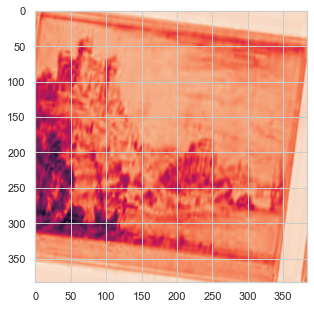

In [13]:
plt.figure(figsize=(5, 5))
train_dataset = TrainDataset(df_train, transform=get_transforms(phase='train'))
image, _ = train_dataset[0]
plt.imshow(image[0])

## DataModule

In [14]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, train_data, valid_data, test_data):
        super().__init__()
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        
    # 必ず呼び出される関数
    def setup(self, stage=None):
        self.train_dataset = TrainDataset(self.train_data, transform=get_transforms(phase='train'))
        self.valid_dataset = TrainDataset(self.valid_data, transform=get_transforms(phase='valid'))
        self.test_dataset = TrainDataset(self.test_data, transform=get_transforms(phase='valid'))
        
    # Trainer.fit() 時にtrain_step()に呼び出される
    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=CFG.loader["train"]["batch_size"],
                          shuffle=True,
                          num_workers=CFG.loader["train"]["num_workers"],
                          pin_memory=True,
                          drop_last=True)

    # Trainer.fit() 時に呼び出される
    def val_dataloader(self):
        return DataLoader(self.valid_dataset,
                          batch_size=CFG.loader["valid"]["batch_size"],
                          shuffle=False,
                          num_workers=CFG.loader["valid"]["num_workers"],
                          pin_memory=True,
                          drop_last=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=CFG.loader["valid"]["batch_size"],
                          shuffle=False,
                          num_workers=CFG.loader["valid"]["num_workers"],
                          pin_memory=True,
                          drop_last=False)

## Pytorch Lightning Module

### LabelSmoothingLoss

In [15]:
class LabelSmoothingLoss(nn.Module):
    """
    https://github.com/bestfitting/instance_level_recognition/blob/main/src/layers/loss.py
    gather:dimで指定された軸に沿って値を収集します。
    LogSoftmaxはSoftmax関数と比較して、誤ったクラス予測に大きなペナルティを課します。
    全ラベルのlossを0.1正解ラベルのロスを0.9の割合で混ぜる
    """
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, logits, labels, epoch=0, **kwargs):
        if self.training:
            logits = logits.float()
            labels = labels.float()
            logprobs = torch.nn.functional.log_softmax(logits, dim=-1)
            # ラベルが2のときはlogprobsのindex=2の値を取得するようなやつ
            nll_loss = -logprobs.gather(dim=-1, index=labels.unsqueeze(1).long())
            nll_loss = nll_loss.squeeze(1)
            smooth_loss = -logprobs.mean(dim=-1)
            loss = self.confidence * nll_loss + self.smoothing * smooth_loss
            loss = loss.mean()
        else:
            loss = F.cross_entropy(logits, labels)
        return loss

class LabelSmoothingLossV1(nn.modules.Module):
    """
    arcfaceの出力(outputとembeddings)ようにlabelsmoothingをwrapperしたクラス
    """
    def __init__(self):
        super(LabelSmoothingLossV1, self).__init__()
        self.classify_loss = LabelSmoothingLoss()

    def forward(self, logits, labels, epoch=0):
        out_face, feature = logits
        loss = self.classify_loss(out_face, labels)
        return loss

In [16]:
# ====================================================
# model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(model_name=self.cfg.model_name,
                                       pretrained=pretrained,
                                       in_chans=self.cfg.in_chans,
                                       num_classes=self.cfg.target_size)
        
    def forward(self, x):
        output = self.model(x)
        return output
    
def get_model(cfg):
    model = CustomModel(cfg, pretrained=cfg.pretrained)
    # plだと要らない？
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.to(device)
    # model.eval()
    return model

# ====================================================
# criterion
# ====================================================
def get_criterion():
    if CFG.criterion_name == 'BCEWithLogitsLoss':
        # plだとto(device)いらない
        criterion = nn.BCEWithLogitsLoss(reduction="mean")
    if CFG.criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    if CFG.criterion_name == "LabelSmoothingLossV1":
        criterion = LabelSmoothingLossV1()
    else:
        raise NotImplementedError
    return criterion
# ====================================================
# optimizer
# ====================================================
def get_optimizer(model: nn.Module, config: dict):
    """
    input:
    model:model
    config:optimizer_nameやlrが入ったものを渡す
    
    output:optimizer
    """
    optimizer_name = config.optimizer_name
    if 'Adam' == optimizer_name:
        return Adam(model.parameters(),
                    lr=config.lr,
                    weight_decay=config.weight_decay,
                    amsgrad=config.amsgrad)
    elif 'RAdam' == optimizer_name:
        return optim.RAdam(model.parameters(),
                           lr=config.lr,
                           weight_decay=config.weight_decay)
    elif 'sgd' == optimizer_name:
        return SGD(model.parameters(),
                   lr=config.lr,
                   momentum=0.9,
                   nesterov=True,
                   weight_decay=config.weight_decay,)
    else:
        raise NotImplementedError

# ====================================================
# scheduler
# ====================================================
def get_scheduler(optimizer):
    if CFG.scheduler=='ReduceLROnPlateau':
        """
        factor : 学習率の減衰率
        patience : 何ステップ向上しなければ減衰するかの値
        eps : nanとかInf回避用の微小数
        """
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
    elif CFG.scheduler=='CosineAnnealingLR':
        """
        T_max : 1 半周期のステップサイズ
        eta_min : 最小学習率(極小値)
        """
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
    elif CFG.scheduler=='CosineAnnealingWarmRestarts':
        """
        T_0 : 初期の繰りかえし回数
        T_mult : サイクルのスケール倍率
        """
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
    else:
        raise NotImplementedError
    return scheduler

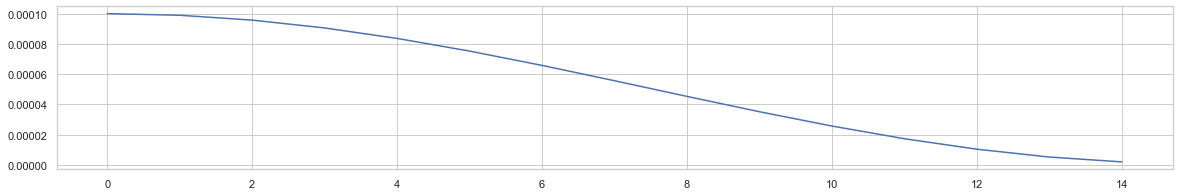

In [17]:
model=timm.create_model(model_name="resnet18",pretrained=False)
optimizer = get_optimizer(model, CFG)
scheduler = get_scheduler(optimizer)
from pylab import rcParams
lrs = []
for epoch in range(1, CFG.T_max+1):
    scheduler.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
rcParams['figure.figsize'] = 20,3
#print(lrs)
plt.plot(lrs)

### Metric learning model

In [18]:
# --------------------------------------
# Arc face
# --------------------------------------
class ArcMarginProduct(nn.Module):
    """
    bestfitting氏のarcmarginproduct2
    label smoothingが入っている
    https://github.com/bestfitting/instance_level_recognition/blob/683f021b4e65876835f028797ec28b0d1071bb45/src/layers/metric_learning.py#L66
    """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps  # label smoothing
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        if label == None:
            return cosine
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine.float() > 0, phi, cosine.float())
        else:
            phi = torch.where(cosine.float() > self.th, phi, cosine.float() - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=label.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output
# --------------------------------------
# GeM Pooling layers
# --------------------------------------
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
    
class Net(nn.Module):
    def __init__(self, args, pretrained=True):
        super(Net, self).__init__()
        
        self.args = args
        self.backbone = timm.create_model(args.model_name, num_classes=0, pretrained=args.pretrained)
        self.global_pool = gem
        self.embedding_size = args.embedding_size
        
        # https://www.groundai.com/project/arcface-additive-angular-margin-loss-for-deep-face-recognition
        if args.neck == "option-D":
            self.neck = nn.Sequential(
                nn.Linear(self.backbone.num_features, self.embedding_size, bias=True),
                nn.BatchNorm1d(self.embedding_size),
                torch.nn.PReLU()
            )
        elif args.neck == "option-F":
            self.neck = nn.Sequential(
                nn.Dropout(0.3),
                nn.Linear(self.backbone.num_features, self.embedding_size, bias=True),
                nn.BatchNorm1d(self.embedding_size),
                torch.nn.PReLU()
            )
        else:
            self.neck = nn.Sequential(
                nn.Linear(self.backbone.num_features, self.embedding_size, bias=False),
                nn.BatchNorm1d(self.embedding_size),
            )
        print(f's:{args.arcface_s},m:{args.arcface_m}')
        self.face_margin_product = ArcMarginProduct(self.embedding_size,
                                                    args.target_size,
                                                    s = args.arcface_s,
                                                    m = args.arcface_m)
    def extract_feature(self, x):
        x = self.backbone.forward_features(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1) #チャネルごとの代表値
        x = self.neck(x)
        return x
        
    def forward(self, ｘ, label, **kargs):
        feature  = self.extract_feature(x)
        out_face = self.face_margin_product(feature, label)
        
        return out_face, feature

In [19]:
# # test
model = Net(CFG)
train_dataset = TrainDataset(df_train, transform=get_transforms(phase='train'))
loader =DataLoader(train_dataset,batch_size=4,num_workers=0,pin_memory=True,drop_last=True)
images, labels = iter(loader).__next__()
out_face, feature = model(images, labels)

# # forward
out_face, feature = model(images, labels)
print(out_face.shape, feature.shape)
# # extract feature
# feature = model.extract_feature(images)
# print(feature.shape)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth" to C:\Users\R/.cache\torch\hub\checkpoints\resnet50d_ra2-464e36ba.pth


s:30,m:0.3
torch.Size([4, 5]) torch.Size([4, 512])


In [20]:
class Trainer(pl.LightningModule):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        print(cfg.model_name)
        self.model = Net(args=cfg)
        self.criterion = get_criterion()
    
    def forward(self, x, y, get_embeddings=False):
        if get_embeddings:
            return self.model.extract_feature(x)
        else:
            return self.model(x, y)
    
    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images, labels) # (out_face, feature)
        # outputs[0].shape,outputs[1].shape
        # > (torch.Size([4, 81313]), torch.Size([4, 512]))
        loss = self.criterion(outputs, labels)
        if type(outputs) == tuple:
            logits = outputs[0]
        else:
            logits = outputs
        probs = F.softmax(logits).data
        train_acc = (probs.argmax(dim=1) == labels).float().mean()
        
        #self.log('train_loss', loss)
        #self.log('train_acc', train_acc)
        self.log_dict(dict(train_loss=loss,train_score=train_acc,))
        
        #return {"loss": loss, "predictions": probs, "labels": labels} # VRAM圧迫
        return {"loss": loss}
    
    def training_epoch_end(self, outputs):
#         preds = []
#         labels = []
        
#         for output in outputs:
#             preds += output['predictions']
#             labels += output['labels']

#         labels = torch.stack(labels)
#         preds = torch.stack(preds)

#         #train_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
#         train_score = accuracy_score(labels.detach().cpu(), preds.argmax(1).detach().cpu())
#         self.log("mean_train_score", train_score, prog_bar=True, logger=True)
#         self.log("lr", self.optimizer.param_groups[0]['lr'], prog_bar=True, logger=True)
        pass
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.forward(images, labels) # (out_face, feature)
        loss = self.criterion(outputs, labels, epoch=epoch)
        if type(outputs) == tuple:
            logits = outputs[0]
        else:
            logits = outputs
        probs = F.softmax(logits).data
        batch_size = len(images)
        valid_acc_batch = (probs.argmax(dim=1) == labels).float().mean()
        
        self.log('val_loss', loss, on_step= True, prog_bar=True, logger=True)
        return {#"predictions": probs,"labels": labels,
                "acc": valid_acc_batch.item(),
                "loss": loss.item()}
    
    def validation_epoch_end(self, outputs):
        
        acc, loss = 0, 0
        for output in outputs:
            acc += output['acc']
            loss += output['loss']
        acc = acc/len(outputs)
        loss = loss/len(outputs)

        #preds = torch.stack(preds)
        #labels = torch.stack(labels)
        #acc = torch.stack(acc)
        #loss = torch.stack(loss)

        #val_auc=roc_auc_score(labels.detach().cpu(), preds.sigmoid().detach().cpu())
        #val_score = accuracy_score(labels.detach().cpu(), preds.argmax(1).detach().cpu())
        #self.log("val_auc", val_auc, prog_bar=True, logger=True)
        #self.log("val_score", val_score, prog_bar=True, logger=True)
        self.log_dict(dict(val_loss=loss,val_score=acc,))
        
        
    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx)
    
    
    def configure_optimizers(self):
        self.optimizer = get_optimizer(self, self.cfg)
        self.scheduler = {'scheduler': get_scheduler(self.optimizer),
                          'interval': 'step', # or 'epoch'
                          'frequency': 1}
        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

## Train

In [21]:
def train() -> None:

    for fold in range(CFG.n_fold):
        if not fold in CFG.trn_fold:
            continue
        print(f"{'='*38} Fold: {fold} {'='*38}")
        # Logger
        #======================================================
        lr_monitor = LearningRateMonitor(logging_interval='step')
        # 学習済重みを保存するために必要
        loss_checkpoint = ModelCheckpoint(
            dirpath=OUTPUT_DIR,
            filename=f"best_loss_fold{fold}",
            monitor="val_loss",
            save_last=True,
            save_top_k=1,
            save_weights_only=True,
            mode="min",
        )
        auc_checkpoint = ModelCheckpoint(
            dirpath=OUTPUT_DIR,
            filename=f"best_auc_fold{fold}",
            monitor="val_score",
            save_top_k=1,
            save_weights_only=True,
            mode="max",
        )
        
        wandb_logger = WandbLogger(
            project='atma11',
            group= f'{CFG.exp_name}',
            name = f'Fold{fold}',
            save_dir=OUTPUT_DIR
        )
        
        data_module = DataModule(
          df_train[df_train['fold']!=fold],
          df_train[df_train['fold']==fold], 
          df_train[df_train['fold']==fold], 
        )
        data_module.setup()
        
        CFG.T_max = int(math.ceil(len(data_module.train_dataloader())/CFG.grad_acc)*CFG.epochs)
        print(f"set schedular T_max {CFG.T_max}")
        #early_stopping_callback = EarlyStopping(monitor='val_auc',mode="max", patience=2)
        
        trainer = pl.Trainer(
            logger=wandb_logger,
            callbacks=[loss_checkpoint, auc_checkpoint, lr_monitor],
            default_root_dir=OUTPUT_DIR,
            gpus=1,
            progress_bar_refresh_rate=1,
            accumulate_grad_batches=CFG.grad_acc,
            max_epochs=CFG.epochs,
            precision=CFG.precision,
            benchmark=False,
            deterministic=True,
        )
        model = Trainer(CFG)
        trainer.fit(model, data_module)
        
        torch.save(model.model.state_dict(),OUTPUT_DIR + '/' + f'{CFG.exp_name}_fold{fold}.pth')
        wandb.finish()
        
        

In [22]:
train()
send_line_notification("[locl]finished")
wandb.finish()

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


====================================== Fold: 0 ======================================
set schedular T_max 240
resnet50d


D:\python\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:424: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


s:30,m:0.3


wandb: wandb version 0.12.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | Net                  | 24.6 M
1 | criterion | LabelSmoothingLossV1 | 0     
---------------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.320    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 29


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

val_loss_step,9.6366
trainer/global_step,159
_step,108
_runtime,354
_timestamp,1631280664
val_loss_epoch,9.18882
val_loss,9.22821
val_score,0.00116
epoch,9
lr-RAdam,3e-05
train_loss,8.82865


val_loss_step,█▇███▇▇▇▇▆▆▇▇▅▆▆▆▅▄▅▅▄▃▄▅▃▃▄▅▃▂▄▃▃▂▃▂▂▁▄
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▂▂▂▃▃▃▃▄▃▃▃▅▃▄▄▄▄▄▄▇▄▄▅█▅▅▅█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
val_loss_epoch,█▇▆▅▄▃▃▂▂▁
val_loss,█▇▆▅▅▃▃▂▂▁
val_score,▁▁▁▁▁▁▁▁▁█
epoch,▁▂▃▃▃▄▅▆▆▆▇██
lr-RAdam,██▅▅▁▁
train_loss,█▃▁


In [23]:
#%debug

In [24]:
# CKPT_PATH ="F:/Kaggle/landmark-recognition-2021/data/output/debug/best_auc_fold0.ckpt"
# checkpoint = torch.load(CKPT_PATH)
# checkpoint.keys()
# model = Trainer(CFG)
# model = model.load_from_checkpoint(cfg=CFG, checkpoint_path=CKPT_PATH)
# #print(checkpoint["hyper_parameters"])
# # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # model = get_model(CFG)
# # model.to(device)
# # model.eval()
# # state_dict = torch.load(checkpoint, map_location=device)
# # model.load_state_dict(state_dict)

In [25]:
# # test
# train_dataset = TrainDataset(df_train, transform=get_transforms(phase='train'))
# loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
# images, labels = iter(loader).__next__()
# model = Net(args=CFG)
# outputs = model(images, labels)
# criterion = get_criterion()
# criterion(outputs, labels)
# for i in range(len(labels)):
#     print(f"正解ラベルインデックス{labels[i]}")
#     print(f"予測ラベルargmin{outputs[0][i].argmin()}")